### Noise-based training of a CTRNN-SDI model using Ornstein-Uhlenbeck adaptation

In [13]:
import jax
import jax.numpy as jnp
import jax.random as jr
import diffrax as dfx
import equinox as eqx
from oua.oua import OUAModel
from neuromorphic_intelligence.models import StochasticDoubleIntegrator, CTRNN, CoupledSystem
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation

# set colormap
cmap = plt.get_cmap("tab10")
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=cmap.colors)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8

# solver = dfx.EulerHeun
solver = dfx.GeneralShARK


Setup system

In [ ]:
# coupled system

agent = CTRNN(num_inputs=2, num_neurons=2, num_outputs=1, noise_scale=0.01)
env = StochasticDoubleIntegrator(mass=1.0, damping_factor=0.5, noise_scale=0.1)
coupled_system = CoupledSystem(agent=agent, env=env)

def reward(t, x, args):
    (agent_state, env_state), agent_params, agent_means, avg_reward = x
    position, velocity = env_state
    tau, A, bias, B, C = agent_params
    u = jax.nn.tanh(jnp.squeeze(C @ agent_state))
    return -0.9 * jnp.linalg.norm(position)**2 - 0.1 * jnp.linalg.norm(u)**2

def custom_output(t, x, args):
    return x, args['reward'](t, x, args)

args = {'reward': reward}

# simulation parameters
key = jr.PRNGKey(42)
t0=0
t1=300
dt0=0.1

# model parameters
param_rate = 2.0
noise_rate = 0.1
mean_rate = 5.0
reward_rate = 2.0

No learning

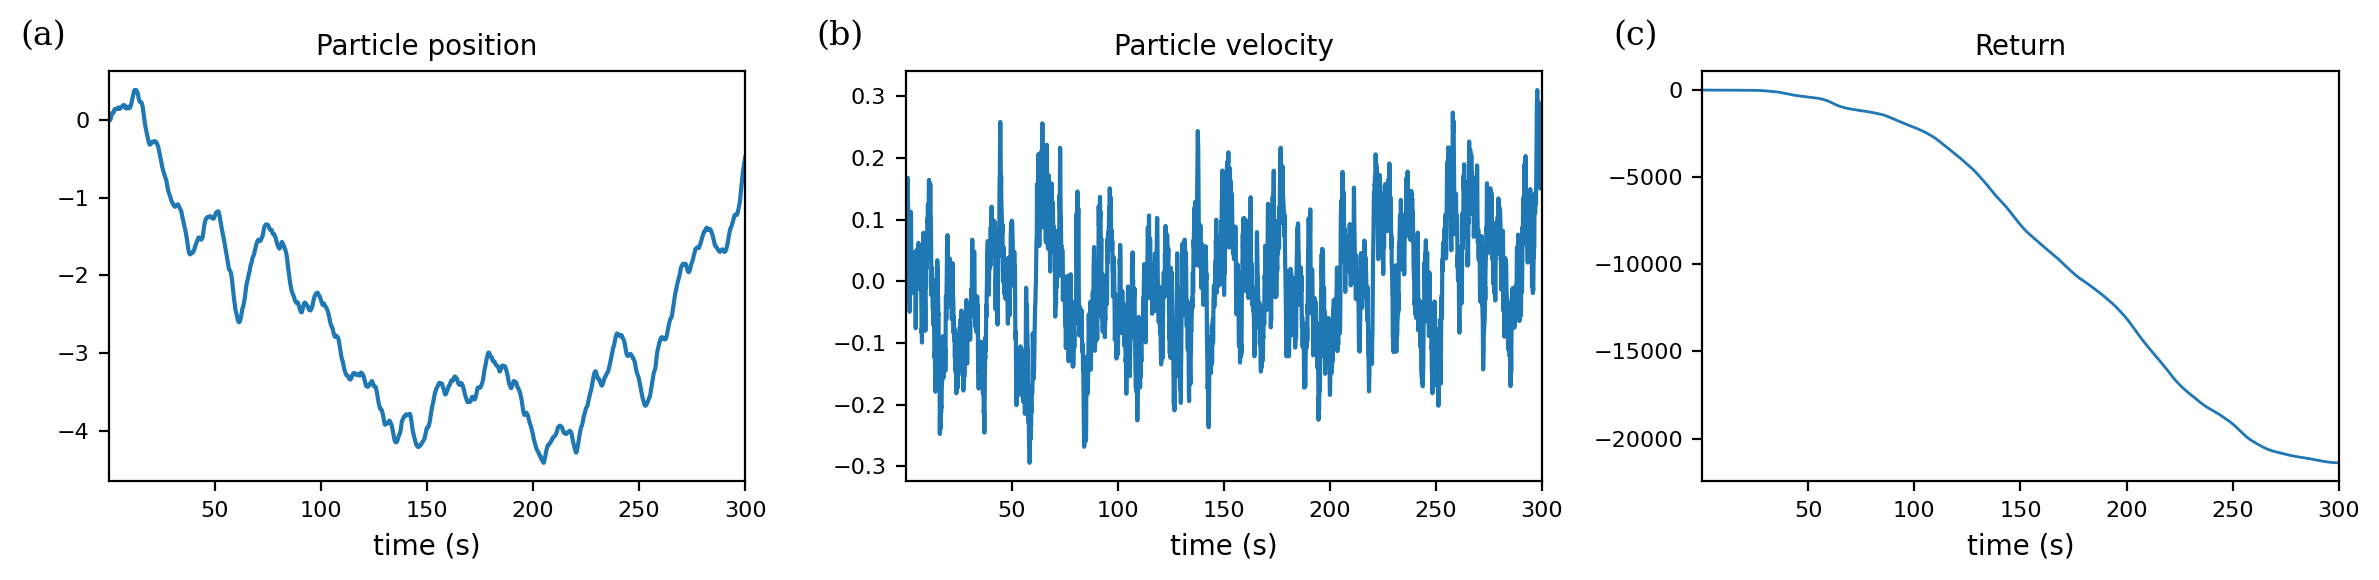

In [15]:
system = OUAModel(model=coupled_system, param_rate=param_rate, noise_rate=0.0, mean_rate=mean_rate, reward_rate=reward_rate)

sol = dfx.diffeqsolve(system.terms(key), solver(), args=args, t0=t0, t1=t1, dt0=dt0, y0=system.initial, saveat=dfx.SaveAt(steps=True, fn=custom_output), adjoint=dfx.DirectAdjoint(), max_steps=int(1e6))

x, reward2 = sol.ys
(agent_state2, env_state2), agent_params2, agent_means2, avg_reward2 = x

fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].plot(sol.ts, env_state2[:,0]);
ax[0].set_title('Particle position');
ax[0].set_xlabel('time (s)')
ax[0].text(0.0, 1.0, '(a)', transform=(
    ax[0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
ax[1].plot(sol.ts, env_state2[:,1]);
ax[1].set_title('Particle velocity');
ax[1].set_xlabel('time (s)')
ax[1].text(0.0, 1.0, '(b)', transform=(
    ax[1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
ax[2].plot(sol.ts, jnp.cumsum(reward2), lw=1.0);
ax[2].set_title('Return');
ax[2].set_xlabel('time (s)')
ax[2].text(0.0, 1.0, '(c)', transform=(
    ax[2].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
for i in range(3):
        ax[i].margins(x=0)

plt.tight_layout()

plt.savefig('../figures/nis_oua_ctrnn_sdi_nolearn.pdf', format='pdf')

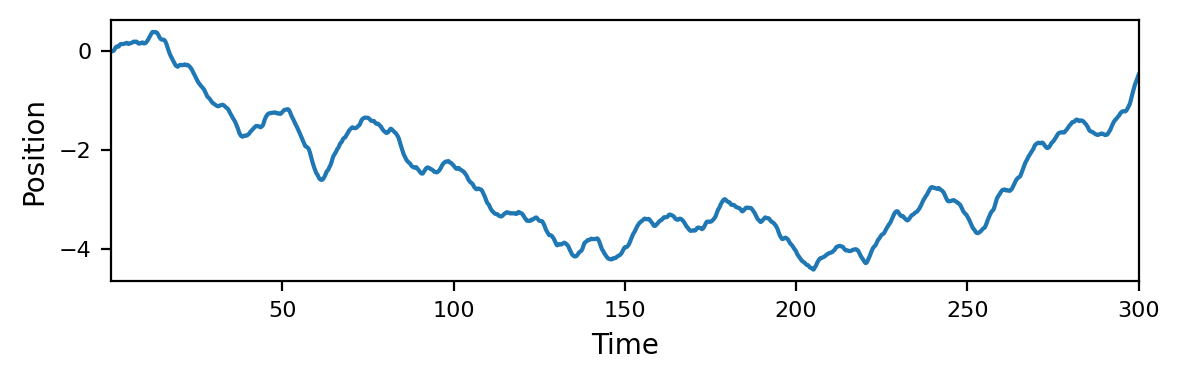

In [16]:
# just the position
fig, ax = plt.subplots(1,1, figsize=(6,2))
ax.plot(sol.ts, env_state2[:,0]);
plt.xlabel('Time')
plt.ylabel('Position')
ax.margins(x=0)
plt.tight_layout()

Learning

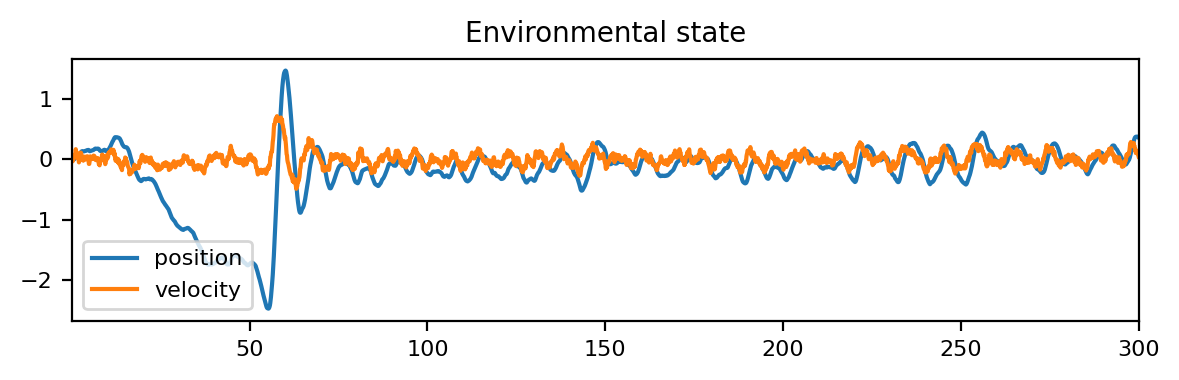

In [17]:
system = OUAModel(model=coupled_system, param_rate=param_rate, noise_rate=noise_rate, mean_rate=mean_rate, reward_rate=reward_rate)

sol = dfx.diffeqsolve(system.terms(key), solver(), args=args, t0=t0, t1=t1, dt0=dt0, y0=system.initial, saveat=dfx.SaveAt(steps=True, fn=custom_output), adjoint=dfx.DirectAdjoint(), max_steps=int(1e6))

x, reward = sol.ys
(agent_state, env_state), agent_params, agent_means, avg_reward = x

fig, ax = plt.subplots(1,1, figsize=(6,2))
ax.plot(sol.ts, env_state);
ax.set_title('Environmental state');
ax.legend(['position', 'velocity'], loc='lower left')#, bbox_to_anchor=(1.0, 0.06, 0.23, 1))
ax.margins(x=0)
plt.tight_layout()



Complete figure

In [18]:
# fig, ax = plt.subplots(3,2, figsize=(8,6), sharex=True)
# fig.align_xlabels(ax)
# fig.align_ylabels(ax)

# ax[0,0].plot(sol.ts, env_state[:,0], lw=1.0);
# ax[0,0].plot(sol.ts, env_state2[:,0], lw=1.0);
# ax[0,0].legend(['learning', 'no learning'], loc='lower right')
# ax[0,0].set_title('Particle position');
# ax[0,0].text(0.0, 1.0, '(a)', transform=(
#     ax[0,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# shape = (len(sol.ts), -1)
# ax[1,0].plot(sol.ts, agent_state, lw=1.0);
# ax[1,0].set_title('Neural dynamics');
# ax[1,0].legend(['neuron 1', 'neuron 2'], loc='lower right')
# ax[1,0].text(0.0, 1.0, '(c)', transform=(
#     ax[1,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')


# ax[2,0].plot(sol.ts, jnp.cumsum(reward), lw=1.0);
# ax[2,0].plot(sol.ts, jnp.cumsum(reward2), lw=1.0);
# ax[2,0].legend(['learning', 'no learning'], loc='lower right')
# ax[2,0].set_title('Return');
# ax[2,0].set_xlabel('time (s)')
# ax[2,0].text(0.0, 1.0, '(e)', transform=(
#     ax[2,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# ax[0,1].plot(sol.ts, env_state[:,1], lw=1.0);
# ax[0,1].plot(sol.ts, env_state2[:,1], lw=1.0);
# ax[0,1].set_title('Particle velocity');
# ax[0,1].legend(['learning', 'no learning'], loc='lower right')
# ax[0,1].text(0.0, 1.0, '(b)', transform=(
#     ax[0,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# for p in agent_means:
#     ax[1,1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, color='k');
# for p in agent_params:
#     ax[1,1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, alpha=0.5);
# ax[1,1].set_title('Parameter dynamics');
# ax[1,1].text(0.0, 1.0, '(d)', transform=(
#     ax[1,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# ax[2,1].plot(sol.ts, reward, lw=1.0);
# ax[2,1].plot(sol.ts, avg_reward, lw=1.0);
# ax[2,1].plot(sol.ts, reward - avg_reward, lw=1.0);
# ax[2,1].legend(['true reward', 'estimated reward', 'RPE'], loc='lower right')
# ax[2,1].set_title('Instantaneous reward');
# ax[2,1].text(0.0, 1.0, '(f)', transform=(
#     ax[2,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')
# ax[2,1].set_xlabel('time (s)')

# for i in range(3):
#     for j in range(2):
#         ax[i,j].margins(x=0)
# plt.tight_layout()

# plt.savefig('../figures/nis_oua_ctrnn_sdi_comb.pdf', format='pdf')

In [19]:
# fig, ax = plt.subplots(3,2, figsize=(8,6), sharex=True)
# fig.align_xlabels(ax)
# fig.align_ylabels(ax)

# ax[0,0].plot(sol.ts, env_state2, lw=1.0);
# ax[0,0].legend(['position', 'velocity'], loc='lower right')
# ax[0,0].set_title('Particle dynamics without learning');
# ax[0,0].text(0.0, 1.0, '(a)', transform=(
#     ax[0,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# shape = (len(sol.ts), -1)
# ax[1,0].plot(sol.ts, agent_state, lw=1.0);
# ax[1,0].set_title('Neural dynamics');
# ax[1,0].legend(['neuron 1', 'neuron 2'], loc='lower right')
# ax[1,0].text(0.0, 1.0, '(c)', transform=(
#     ax[1,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')


# ax[2,0].plot(sol.ts, jnp.cumsum(reward), lw=1.0);
# ax[2,0].plot(sol.ts, jnp.cumsum(reward2), lw=1.0);
# ax[2,0].legend(['learning', 'no learning'], loc='lower right')
# ax[2,0].set_title('Return');
# ax[2,0].set_xlabel('time (s)')
# ax[2,0].text(0.0, 1.0, '(e)', transform=(
#     ax[2,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# ax[0,1].plot(sol.ts, env_state, lw=1.0);
# ax[0,1].legend(['position', 'velocity'], loc='lower right')
# ax[0,1].set_title('Particle dynamics with learning');
# ax[0,1].text(0.0, 1.0, '(b)', transform=(
#     ax[0,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# for p in agent_means:
#     ax[1,1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, color='k');
# for p in agent_params:
#     ax[1,1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, alpha=0.5);
# ax[1,1].set_title('Parameter dynamics');
# ax[1,1].text(0.0, 1.0, '(d)', transform=(
#     ax[1,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')

# ax[2,1].plot(sol.ts, reward, lw=1.0);
# ax[2,1].plot(sol.ts, avg_reward, lw=1.0);
# ax[2,1].plot(sol.ts, reward - avg_reward, lw=1.0);
# ax[2,1].legend(['true reward', 'estimated reward', 'RPE'], loc='lower right')
# ax[2,1].set_title('Instantaneous reward');
# ax[2,1].text(0.0, 1.0, '(f)', transform=(
#     ax[2,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
#     fontsize='large', va='bottom', fontfamily='serif')
# ax[2,1].set_xlabel('time (s)')

# for i in range(3):
#     for j in range(2):
#         ax[i,j].margins(x=0)
# plt.tight_layout()

# plt.savefig('../figures/nis_oua_ctrnn_sdi_comb.pdf', format='pdf')

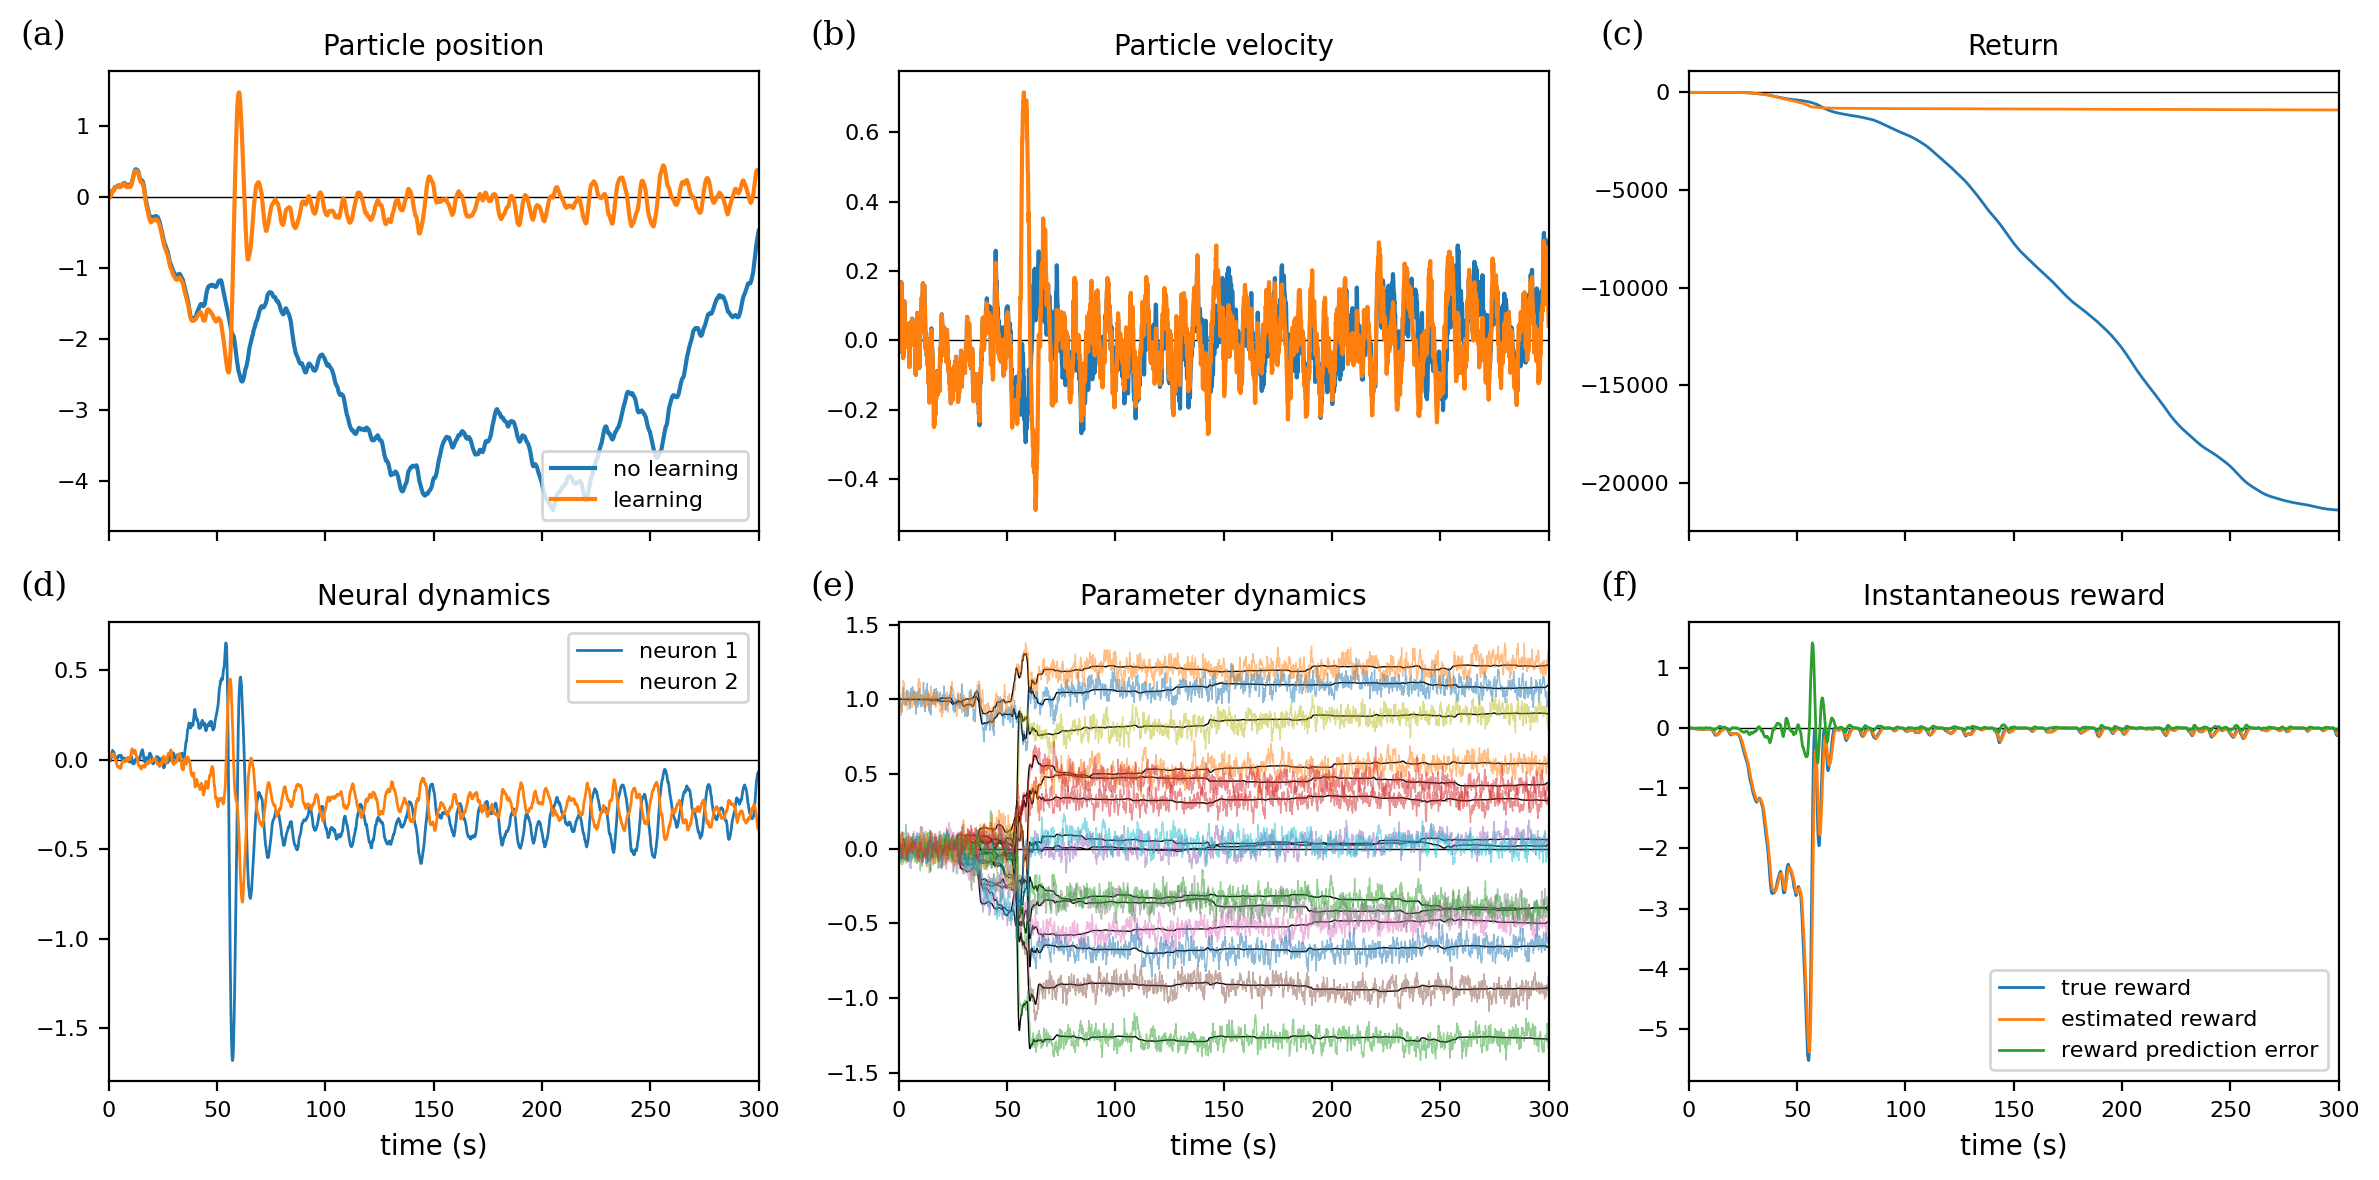

In [20]:
import seaborn as sns

with sns.color_palette("tab10"):

    fig, ax = plt.subplots(2,3, figsize=(12,6), sharex=True)
    fig.align_xlabels(ax)
    fig.align_ylabels(ax)

    ax[0,0].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[0,0].plot(sol.ts, env_state2[:,0],label='no learning')
    ax[0,0].plot(sol.ts, env_state[:,0],label='learning')
    ax[0,0].legend(loc='lower right')
    ax[0,0].set_title('Particle position');
    ax[0,0].text(0.0, 1.0, '(a)', transform=(
        ax[0,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    ax[0,1].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[0,1].plot(sol.ts, env_state2[:,1]);
    ax[0,1].plot(sol.ts, env_state[:,1]);
    ax[0,1].set_title('Particle velocity');
    ax[0,1].text(0.0, 1.0, '(b)', transform=(
        ax[0,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    ax[0,2].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[0,2].plot(sol.ts, jnp.cumsum(reward2), lw=1.0);
    ax[0,2].plot(sol.ts, jnp.cumsum(reward), lw=1.0);
    ax[0,2].set_title('Return');
    ax[0,2].text(0.0, 1.0, '(c)', transform=(
        ax[0,2].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    shape = (len(sol.ts), -1)
    ax[1,0].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[1,0].plot(sol.ts, agent_state, lw=1.0);0
    ax[1,0].set_title('Neural dynamics');
    ax[1,0].set_xlabel('time (s)')
    ax[1,0].legend(['neuron 1', 'neuron 2'], loc='upper right')
    ax[1,0].text(0.0, 1.0, '(d)', transform=(
        ax[1,0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    ax[1,1].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    for p in agent_means:
        ax[1,1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, color='k');
    for p in agent_params:
        ax[1,1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, alpha=0.5);
    ax[1,1].set_title('Parameter dynamics');
    ax[1,1].set_xlabel('time (s)')
    ax[1,1].text(0.0, 1.0, '(e)', transform=(
        ax[1,1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')

    ax[1,2].plot([0, t1], [0.0, 0.0], 'k-', lw=0.5,label='_nolegend_')
    ax[1,2].plot(sol.ts, reward, lw=1.0);
    ax[1,2].plot(sol.ts, avg_reward, lw=1.0);
    ax[1,2].plot(sol.ts, reward - avg_reward, lw=1.0);
    ax[1,2].legend(['true reward', 'estimated reward', 'reward prediction error'], loc='lower right')
    ax[1,2].set_title('Instantaneous reward');
    ax[1,2].text(0.0, 1.0, '(f)', transform=(
        ax[1,2].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
        fontsize='large', va='bottom', fontfamily='serif')
    ax[1,2].set_xlabel('time (s)')

    for i in range(2):
        for j in range(3):
            ax[i,j].margins(x=0)

    plt.tight_layout()

plt.savefig('../figures/nis_oua_ctrnn_sdi_comb.pdf', format='pdf')

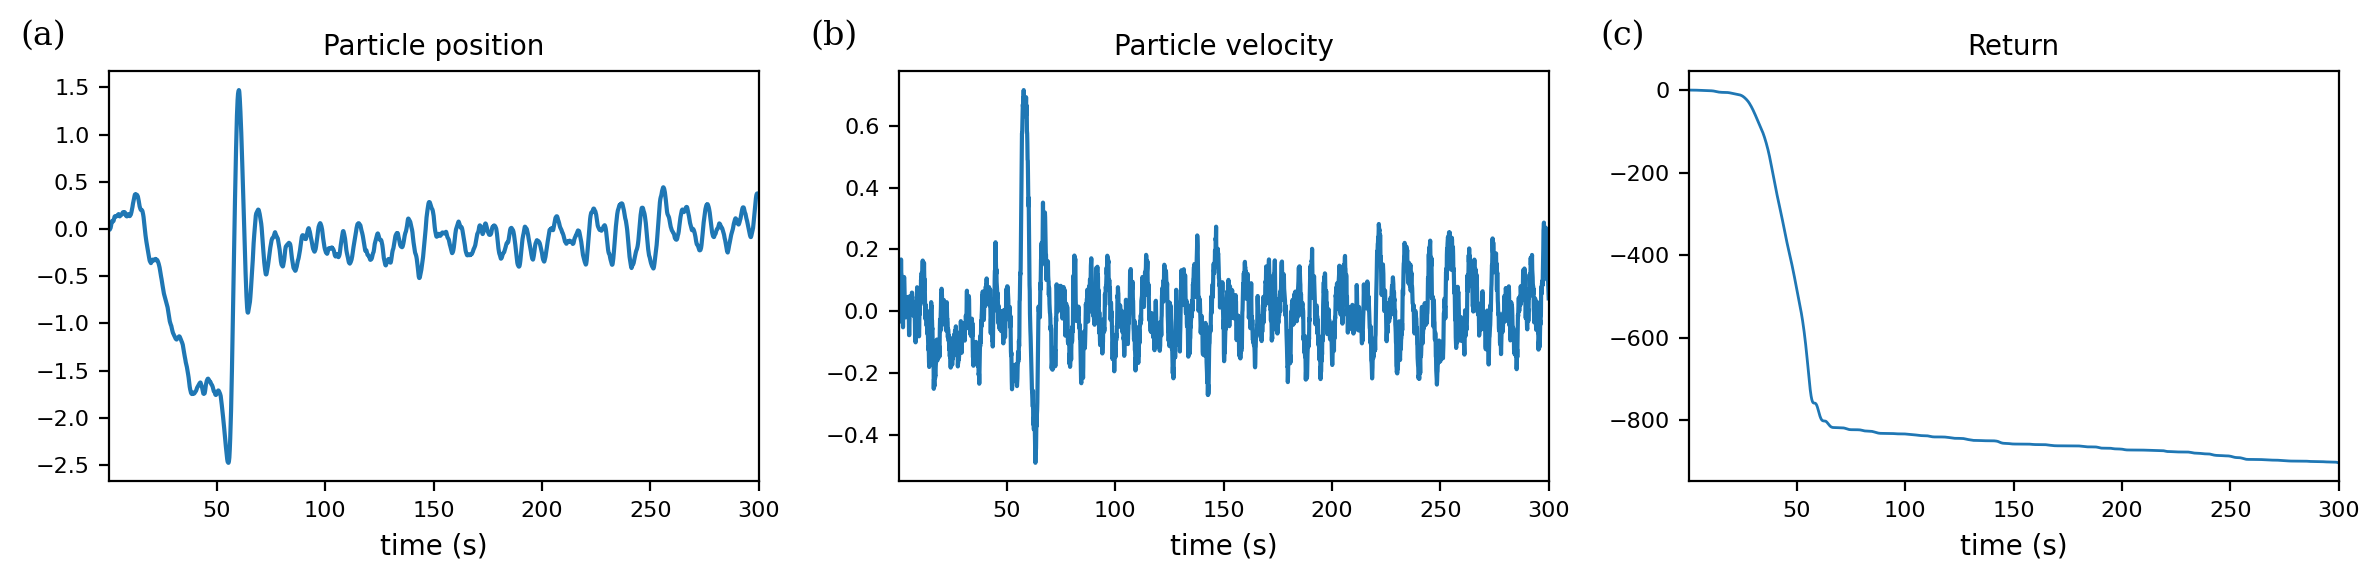

In [21]:
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].plot(sol.ts, env_state[:,0]);
ax[0].set_title('Particle position');
ax[0].set_xlabel('time (s)')
ax[0].text(0.0, 1.0, '(a)', transform=(
    ax[0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
ax[1].plot(sol.ts, env_state[:,1]);
ax[1].set_title('Particle velocity');
ax[1].set_xlabel('time (s)')
ax[1].text(0.0, 1.0, '(b)', transform=(
    ax[1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
ax[2].plot(sol.ts, jnp.cumsum(reward), lw=1.0);
ax[2].set_title('Return');
ax[2].set_xlabel('time (s)')
ax[2].text(0.0, 1.0, '(c)', transform=(
    ax[2].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
for i in range(3):
        ax[i].margins(x=0)

plt.tight_layout()

plt.savefig('../figures/nis_oua_ctrnn_sdi_learn.pdf', format='pdf')

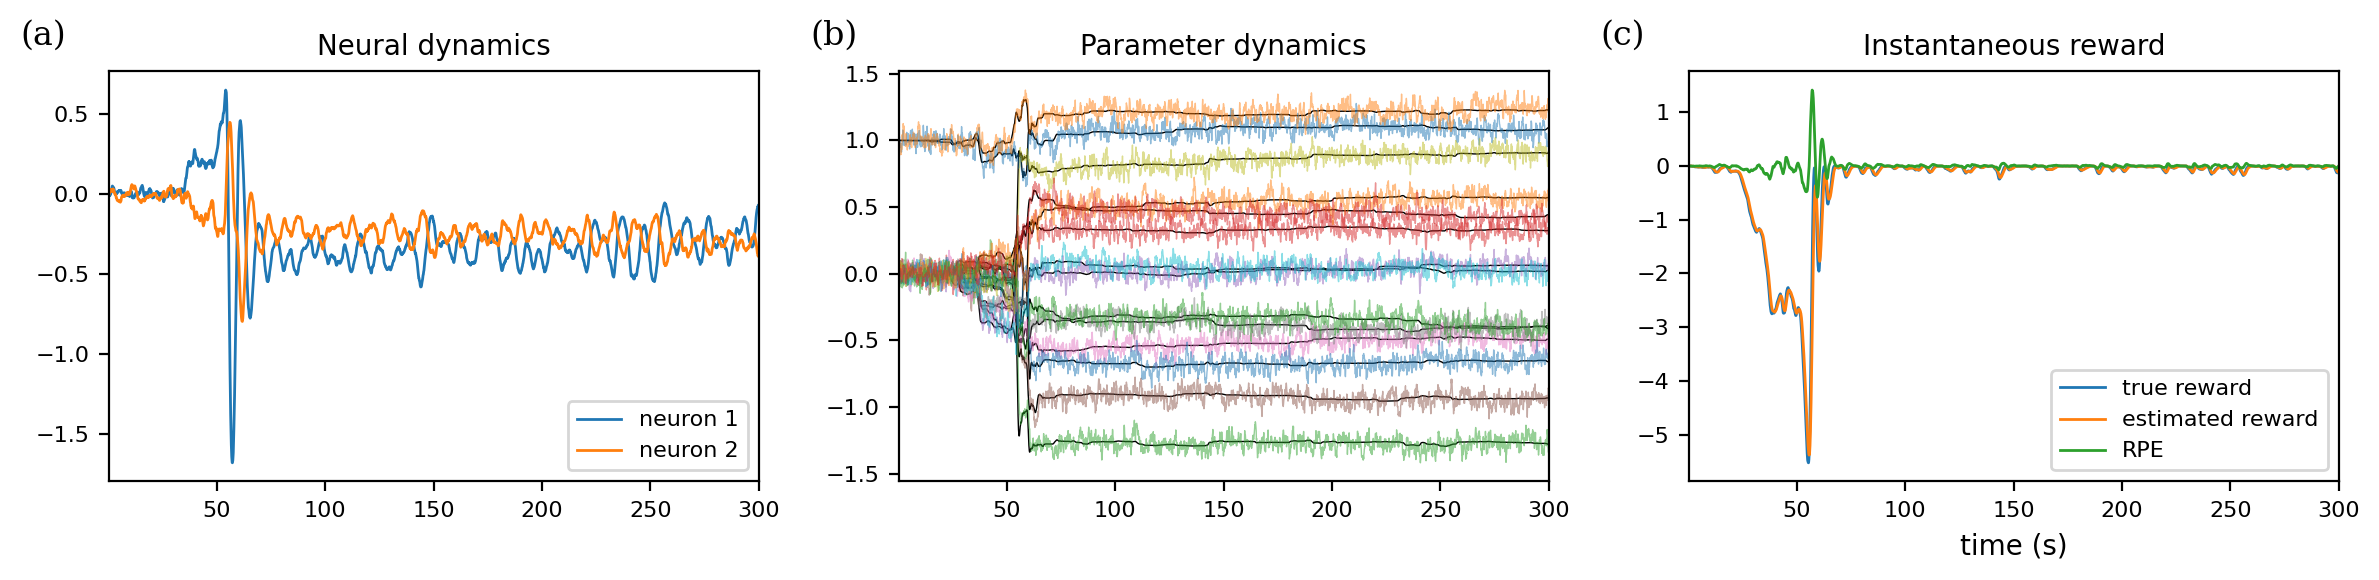

In [22]:
fig, ax = plt.subplots(1,3, figsize=(12,3), sharex=True)
fig.align_xlabels(ax)
fig.align_ylabels(ax)

shape = (len(sol.ts), -1)
ax[0].plot(sol.ts, agent_state, lw=1.0);
ax[0].set_title('Neural dynamics');
ax[0].legend(['neuron 1', 'neuron 2'], loc='lower right')
ax[0].text(0.0, 1.0, '(a)', transform=(
    ax[0].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

for p in agent_means:
    ax[1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, color='k');
for p in agent_params:
    ax[1].plot(sol.ts, jnp.reshape(p, shape), lw=0.5, alpha=0.5);
ax[1].set_title('Parameter dynamics');
ax[1].text(0.0, 1.0, '(b)', transform=(
    ax[1].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')

ax[2].plot(sol.ts, reward, lw=1.0);
ax[2].plot(sol.ts, avg_reward, lw=1.0);
ax[2].plot(sol.ts, reward - avg_reward, lw=1.0);
ax[2].legend(['true reward', 'estimated reward', 'RPE'], loc='lower right')
ax[2].set_title('Instantaneous reward');
ax[2].text(0.0, 1.0, '(c)', transform=(
    ax[2].transAxes + ScaledTranslation(-32/72, +7/72, fig.dpi_scale_trans)),
    fontsize='large', va='bottom', fontfamily='serif')
ax[2].set_xlabel('time (s)')

for i in range(3):
        ax[i].margins(x=0)
plt.tight_layout()

plt.savefig('../figures/nis_oua_ctrnn_sdi_learn_dynamics.pdf', format='pdf')

Animation of learning and no learning behaviour

In [23]:
from matplotlib.animation import FuncAnimation
import seaborn as sns
import numpy as np
from IPython.display import HTML

def animate2d(xs, fig, ax, n=20, size=50, interval=20, palette="crest"):
    """
    Animate a 2D scatter plot with a trailing effect.
    Parameters:
    xs : numpy.ndarray
        A 2D array of shape (num_frames, 2) containing the x and y coordinates for each frame.
    fig : matplotlib.figure.Figure
    ax : matplotlib.axes.Axes
        The matplotlib Axes object where the animation will be plotted.
    n : int, optional
        The number of trailing points to display in the animation (default is 20).
    size : int, optional
        The size of the scatter points (default is 50).
    interval : int, optional
        The interval between frames in milliseconds (default is 20).
    palette : str, optional
        The name of the Seaborn color palette to use for the trailing points (default is "crest").
    Returns:
    matplotlib.animation.FuncAnimation
        The animation object that can be displayed or saved.
    """

    # Get a Seaborn palette
    palette = sns.color_palette(palette, n+1)

    # Initialize scatter points
    points = ax.scatter([], [], s=size, facecolor=[], edgecolor="none", zorder=2)

    # Transparency for each point
    alphas = np.linspace(0.1, 1.0, n)

    def init():
        points.set_offsets(np.empty((0, 2)))  # Empty 2D array for initialization
        points.set_facecolor([])  # Initialize empty colors
        return points,

    def update(frame):

        # Select trailing frames
        start = max(0, frame - n)
        x_trail = xs[start:(frame+1), 0]
        y_trail = xs[start:(frame+1), 1]

        # Use colors from the Seaborn palette for the trailing points
        trail_length = len(x_trail)

        # Add transparency to colors
        rgba_colors = [(*rgb, alpha) for rgb, alpha in zip(palette[-trail_length:], alphas[-trail_length:])]  # Add alpha to RGB

        # Update scatter plot
        points.set_offsets(np.column_stack((x_trail, y_trail)))  # Update data points
        points.set_facecolor(rgba_colors)  # Apply RGBA colors to the fill
        return points,

    plt.close(fig)
    return FuncAnimation(fig, update, frames=len(xs)+n, init_func=init, blit=True, interval=interval)

In [24]:
import matplotlib as mpl

fts = ~jnp.isinf(env_state[:, 0])
xs = env_state[fts,:]
xs = xs[:-1:50, :]

fts = ~jnp.isinf(env_state2[:, 0])
xs2 = env_state2[fts,:]
xs2 = xs2[:-1:50, :]

mmax = 1.3 * jnp.max(jnp.abs(jnp.vstack([jnp.ravel(xs), jnp.ravel(xs2)])))

xmin = ymin = -mmax
xmax = ymax = mmax

with mpl.style.context('dark_background'):
    fig, ax = plt.subplots()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.grid(True)
    plt.tight_layout()

mpl.rcParams['animation.embed_limit'] = 100  # Set embed limit to 100 MB

# 30000 xs[:1000]
ani = animate2d(xs, fig, ax, interval=20, n=30, palette="hot")

# Display the animation in the notebook (can take a long time to render)
# HTML(ani.to_jshtml())

# Or save the animation as a movie file
ani.save('../figures/anim_trained.mp4', writer='ffmpeg', fps=20)


MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [ ]:
with mpl.style.context('dark_background'):
    fig, ax = plt.subplots()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.grid(True)
    plt.tight_layout()

mpl.rcParams['animation.embed_limit'] = 100  # Set embed limit to 100 MB

# 30000 xs[:1000]
ani = animate2d(xs2, fig, ax, interval=20, n=30, palette="hot")

# Display the animation in the notebook (can take a long time to render)
# HTML(ani.to_jshtml())

# Or save the animation as a movie file
ani.save('../figures/anim_untrained.mp4', writer='ffmpeg', fps=20)
